In [1]:
import tensorflow as tf
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

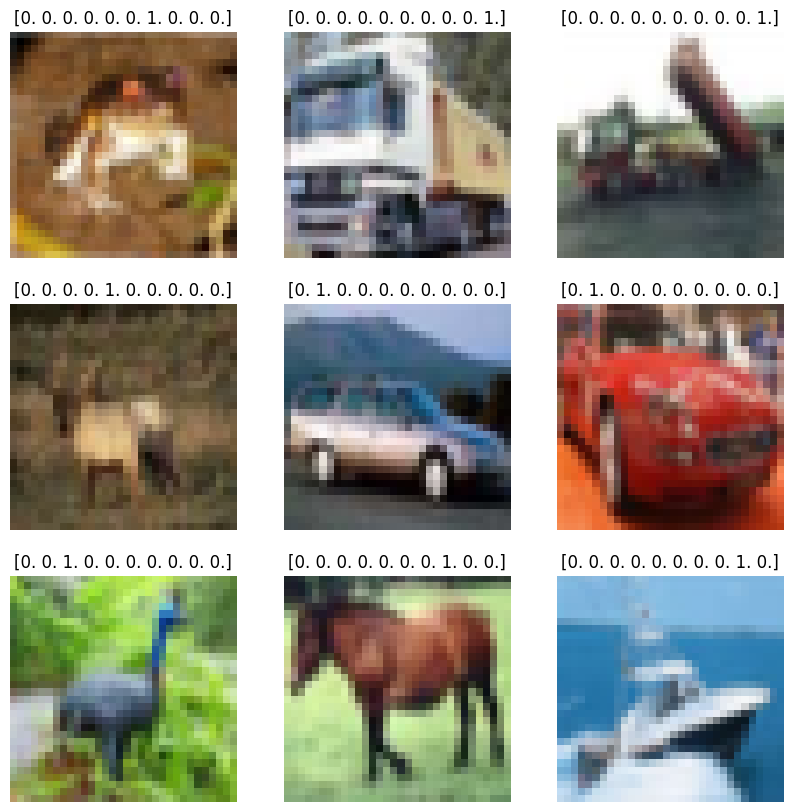

In [2]:
from scipy.ndimage import rotate

# Load MNIST dataset
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()
(X_train, X_test) = (X_train.astype(np.float32), X_test.astype(np.float32))
(X_train, X_test) = (X_train / 255.0, X_test / 255.0)


y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)


#Plot some images
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    ax.imshow(X_train[i])
    ax.set_title(y_train[i])
    ax.axis('off')

In [14]:
# Enhanced Vision Transformer Model
class EnhancedVisionTransformer(tf.keras.Model):
    def __init__(self, patch_size, embedding_dim=128, num_heads=8, num_classes=10):
        super(EnhancedVisionTransformer, self).__init__()

        self.patch_size = patch_size
        self.embedding_dim = embedding_dim
        self.num_heads = num_heads

        # Patch embedding via Conv2D layer
        self.patch_embedding = tf.keras.layers.Conv2D(embedding_dim, patch_size, strides=patch_size, padding='valid')

        # Positional Encoding Layer
        max_patches = (32 // patch_size) ** 2  # For CIFAR-10 with 32x32 images
        self.position_embedding = tf.keras.layers.Embedding(max_patches, embedding_dim)

        # Multi-Head Attention Layer
        self.multi_head_attention = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=embedding_dim)

        # Feed Forward Network (FFN)
        self.ffn = tf.keras.Sequential([
            tf.keras.layers.Dense(embedding_dim, activation='relu'),
            tf.keras.layers.Dense(embedding_dim)
        ])

        # Output layer
        self.flatten = tf.keras.layers.Flatten()
        self.dense = tf.keras.layers.Dense(num_classes, activation="softmax")

    def call(self, inputs):
        # Patch embedding
        patches = self.patch_embedding(inputs)

        # Reshape to sequence of patches
        batch_size = tf.shape(patches)[0]
        h, w = patches.shape[1], patches.shape[2]
        num_patches = h * w
        patches = tf.reshape(patches, [batch_size, num_patches, self.embedding_dim])
    

        # Add positional encoding
        positions = tf.range(0, num_patches, dtype=tf.int32)
        pos_encoding = self.position_embedding(positions)  # [num_patches, embedding_dim]
        patches = patches + pos_encoding

        # Multi-head attention
        attention_output = self.multi_head_attention(query=patches, value=patches, key=patches)

        # Feed-forward network
        ffn_output = self.ffn(attention_output)

        # Final classification
        x = self.flatten(ffn_output)
        output = self.dense(x)

        return output

In [4]:
class LightweightVisionTransformer(tf.keras.Model):
    def __init__(self, patch_size, embedding_dim=64, num_heads=4, num_classes=10):
        super(LightweightVisionTransformer, self).__init__()

        self.patch_size = patch_size
        self.embedding_dim = embedding_dim
        self.num_heads = num_heads

        # Use a smaller embedding dimension (64 instead of 128)
        self.patch_embedding = tf.keras.layers.Conv2D(embedding_dim, patch_size, strides=patch_size, padding='valid')
        
        max_patches = (32 // patch_size) ** 2
        self.position_embedding = tf.keras.layers.Embedding(max_patches, embedding_dim)
        
        # Fewer attention heads (4 instead of 8)
        self.layer_norm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.multi_head_attention = tf.keras.layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embedding_dim//num_heads)
        
        # MLP with bottleneck architecture
        self.layer_norm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.ffn = tf.keras.Sequential([
            tf.keras.layers.Dense(embedding_dim//2, activation='gelu'),  # Bottleneck
            tf.keras.layers.Dense(embedding_dim)
        ])
        
        # Global pooling instead of flatten to drastically reduce parameters
        self.global_avg_pool = tf.keras.layers.GlobalAveragePooling1D()
        self.dense = tf.keras.layers.Dense(num_classes, activation="softmax")

    def call(self, inputs):
        # Patch embedding
        patches = self.patch_embedding(inputs)
        
        batch_size = tf.shape(patches)[0]
        h, w = patches.shape[1], patches.shape[2]
        num_patches = h * w
        patches = tf.reshape(patches, [batch_size, num_patches, self.embedding_dim])

        # Add positional encoding
        positions = tf.range(0, num_patches, dtype=tf.int32)
        pos_encoding = self.position_embedding(positions)
        x = patches + pos_encoding

        # Transformer block with residual connections
        residual = x
        x = self.layer_norm1(x)
        x = self.multi_head_attention(query=x, value=x, key=x)
        x = x + residual  # Residual connection

        # FFN block with residual connections
        residual = x
        x = self.layer_norm2(x)
        x = self.ffn(x)
        x = x + residual  # Residual connection

        # Use global pooling instead of flatten
        x = self.global_avg_pool(x)
        output = self.dense(x)

        return output

In [15]:
# Simple and clean CNN model
def build_cnn_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),

        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),

        tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(10, activation='softmax')
    ])
    return model

In [16]:
# Function for training and evaluating models
def train_and_evaluate(model, x_train, y_train, x_test, y_test, model_name="Model"):
    
    test_acc = []
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

    # Track training time
    start_time = time.time()
    history = model.fit(x_train, y_train, epochs=20, batch_size=64, validation_split=0.1, verbose=2)
    end_time = time.time()

    training_duration = (end_time - start_time) / 60

    # Evaluation
    loss, accuracy = model.evaluate(x_test, y_test)
    test_acc.append(accuracy)
    print(f"{model_name} - Training time: {training_duration:.2f} minutes")
    print(f"{model_name} - Test Accuracy: {accuracy:.4f}")

    # Confusion Matrix
    y_pred = np.argmax(model.predict(x_test), axis=-1)
    y_true = np.argmax(y_test, axis=-1)
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.arange(10), yticklabels=np.arange(10))
    plt.title(f'{model_name} - Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    return test_acc


Training CNN Model on original CIFAR10 dataset:


c:\Users\emman\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
1407/1407 - 59s - 42ms/step - accuracy: 0.4763 - loss: 1.4808 - val_accuracy: 0.5696 - val_loss: 1.2023
Epoch 2/10
1407/1407 - 63s - 45ms/step - accuracy: 0.6241 - loss: 1.0781 - val_accuracy: 0.6200 - val_loss: 1.0698
Epoch 3/10
1407/1407 - 54s - 39ms/step - accuracy: 0.6802 - loss: 0.9132 - val_accuracy: 0.6312 - val_loss: 1.0699
Epoch 4/10
1407/1407 - 62s - 44ms/step - accuracy: 0.7217 - loss: 0.8018 - val_accuracy: 0.5882 - val_loss: 1.2450
Epoch 5/10
1407/1407 - 76s - 54ms/step - accuracy: 0.7461 - loss: 0.7237 - val_accuracy: 0.7294 - val_loss: 0.7925
Epoch 6/10
1407/1407 - 122s - 87ms/step - accuracy: 0.7753 - loss: 0.6444 - val_accuracy: 0.7452 - val_loss: 0.7844
Epoch 7/10
1407/1407 - 72s - 51ms/step - accuracy: 0.7962 - loss: 0.5836 - val_accuracy: 0.7538 - val_loss: 0.7719
Epoch 8/10
1407/1407 - 123s - 87ms/step - accuracy: 0.8165 - loss: 0.5212 - val_accuracy: 0.7680 - val_loss: 0.7385
Epoch 9/10
1407/1407 - 61s - 43ms/step - accuracy: 0.8342 - loss: 0.4680 - val

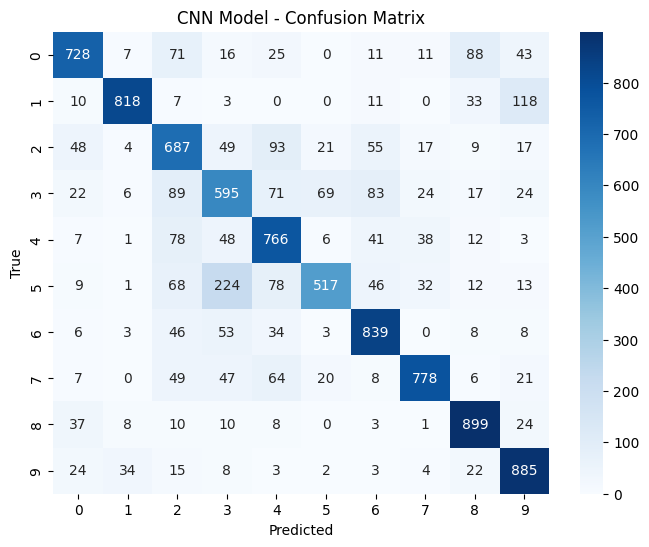

In [17]:
# Train and evaluate CNN Model
print("\nTraining CNN Model on original CIFAR10 dataset:")
cnn_model = build_cnn_model()
cnn_test_acc = train_and_evaluate(cnn_model, X_train, y_train, X_test, y_test, model_name="CNN Model")


Training ViT Model on original CIFAR10 dataset:
Epoch 1/20
704/704 - 21s - 29ms/step - accuracy: 0.6298 - loss: 1.0251 - val_accuracy: 0.5608 - val_loss: 1.2633
Epoch 2/20
704/704 - 21s - 29ms/step - accuracy: 0.6325 - loss: 1.0173 - val_accuracy: 0.5570 - val_loss: 1.2710
Epoch 3/20
704/704 - 10s - 14ms/step - accuracy: 0.6353 - loss: 1.0142 - val_accuracy: 0.5598 - val_loss: 1.2665
Epoch 4/20
704/704 - 10s - 14ms/step - accuracy: 0.6336 - loss: 1.0128 - val_accuracy: 0.5554 - val_loss: 1.2723
Epoch 5/20
704/704 - 11s - 16ms/step - accuracy: 0.6363 - loss: 1.0064 - val_accuracy: 0.5512 - val_loss: 1.2799
Epoch 6/20
704/704 - 10s - 14ms/step - accuracy: 0.6383 - loss: 1.0035 - val_accuracy: 0.5516 - val_loss: 1.2819
Epoch 7/20
704/704 - 10s - 14ms/step - accuracy: 0.6384 - loss: 1.0021 - val_accuracy: 0.5564 - val_loss: 1.2738
Epoch 8/20
704/704 - 11s - 15ms/step - accuracy: 0.6398 - loss: 0.9967 - val_accuracy: 0.5544 - val_loss: 1.2920
Epoch 9/20
704/704 - 13s - 19ms/step - accuracy

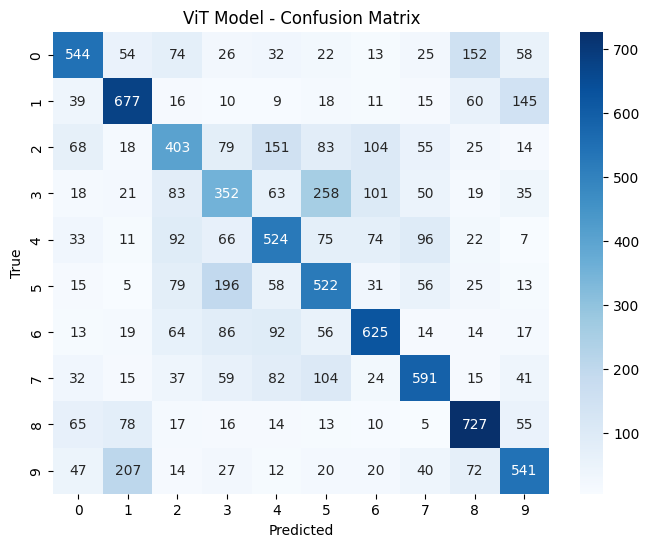

In [17]:
print("\nTraining ViT Model on original CIFAR10 dataset:")
#vit_model = LightweightVisionTransformer(patch_size=8)
vit_test_acc = train_and_evaluate(vit_model, X_train, y_train, X_test, y_test, model_name="ViT Model")

In [8]:
vit_model.summary()

Model: "lightweight_vision_transformer_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 4, 4, 64)       │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_1 (Embedding)         │ (16, 64)               │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_2           │ (None, 16, 64)         │           128 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ multi_head_attention_1          │ (None, 16, 64)         │        16,640 │
│ (MultiHeadAttention)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_3           │ (None, 16, 64)         │           128 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 16, 64)         │         4,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ ?                      │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 105,344 (411.50 KB)

 Trainable params: 35,114 (137.16 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 70,230 (274.34 KB)

Applied variable permutations across all 50000 images
Transformed dataset saved at ../data/CIFAR10/X_train_transformed.npy
Applied variable permutations across all 10000 images
Transformed dataset saved at ../data/CIFAR10/X_test_transformed.npy
(50000, 32, 32, 3) (10000, 32, 32, 3)


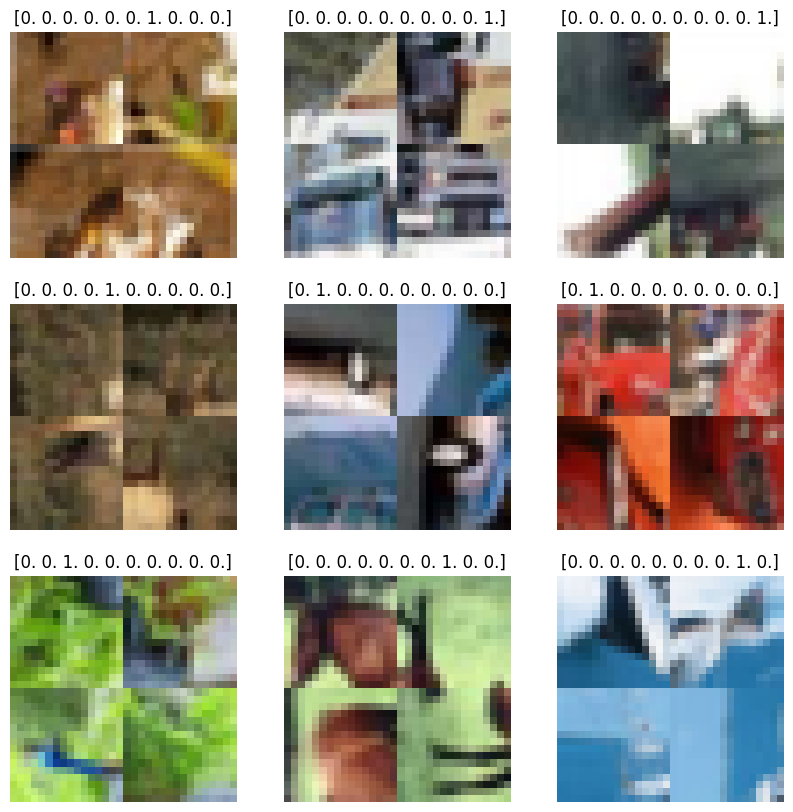

In [3]:
import numpy as np
import os
from scipy.ndimage import rotate

def transform_dataset(X, saving_path=None, load_trasformed=False):
    if load_trasformed and os.path.exists(saving_path):
        print(f"Loading transformed dataset from {saving_path}")
        X_transformed = np.load(saving_path)
    else:
        # Divides each image of the dataset in 4 quadrants and rotates them
        X_transformed = np.zeros_like(X)
        X_transformed[:, :16, :16] = X[:, :16, :16]
        X_transformed[:, :16, 16:] = rotate(X[:, :16, 16:], 90, axes=(1, 2))
        X_transformed[:, 16:, :16] = rotate(X[:, 16:, :16], 180, axes=(1, 2))
        X_transformed[:, 16:, 16:] = rotate(X[:, 16:, 16:], 270, axes=(1, 2))

        # Shuffle the 4 patches of each image with variable permutations
        np.random.seed(42)  # For reproducibility
        n_samples = X.shape[0]
        
        # Store rotated images for reference
        X_rotated = np.copy(X_transformed)
        
        # Define quadrant positions - each is (height_slice, width_slice)
        quad_slices = [
            (slice(0, 16), slice(0, 16)),    # top-left (0)
            (slice(0, 16), slice(16, 32)),   # top-right (1)
            (slice(16, 32), slice(0, 16)),   # bottom-left (2)
            (slice(16, 32), slice(16, 32))   # bottom-right (3)
        ]
        
        # Extract all quadrants at once into a 5D array: (images, quadrants, height, width, channels)
        # This avoids repeated slicing operations
        all_quads = np.zeros((n_samples, 4, 16, 16, 3), dtype=X.dtype)
        for q in range(4):
            h_slice, w_slice = quad_slices[q]
            all_quads[:, q] = X_rotated[:, h_slice, w_slice]
        
        # Generate all permutations at once (n_samples × 4 array)
        all_perms = np.array([np.random.permutation(4) for _ in range(n_samples)])
        
        # Process in batches to limit memory usage
        batch_size = 5000  # Adjust based on available memory
        for start in range(0, n_samples, batch_size):
            end = min(start + batch_size, n_samples)
            
            # Apply permutations to this batch using vectorized operations
            for dst_pos in range(4):
                # Get destination quadrant slice
                dst_h, dst_w = quad_slices[dst_pos]
                
                # For each image in batch, get source quadrant index
                for i in range(start, end):
                    src_quad = all_perms[i, dst_pos]
                    X_transformed[i, dst_h, dst_w] = all_quads[i, src_quad]

        print(f"Applied variable permutations across all {n_samples} images")

        if saving_path is not None:
            os.makedirs(os.path.dirname(saving_path), exist_ok=True)
            np.save(saving_path, X_transformed)
            print(f"Transformed dataset saved at {saving_path}")
        
    return X_transformed

# Replace your transformation code with:
load_transformed = False

X_train_transformed = transform_dataset(X_train, saving_path='../data/CIFAR10/X_train_transformed.npy', load_trasformed=load_transformed)
X_test_transformed = transform_dataset(X_test, saving_path='../data/CIFAR10/X_test_transformed.npy', load_trasformed=load_transformed)
    

print(X_train_transformed.shape, X_test_transformed.shape)  # Should be same shape as original dataset

# try:
#     del X_train, X_test
# except:
#     pass

# Plot transformed images
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    transformed_img = X_train_transformed[i]
    ax.imshow(transformed_img)  # Convert to uint8 for proper display
    ax.set_title(y_train[i])
    ax.axis('off')


Training CNN Model on modified CIFAR10 dataset:


c:\Users\emman\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
1407/1407 - 131s - 93ms/step - accuracy: 0.4218 - loss: 1.5975 - val_accuracy: 0.4396 - val_loss: 1.5989
Epoch 2/10
1407/1407 - 92s - 65ms/step - accuracy: 0.5562 - loss: 1.2368 - val_accuracy: 0.5062 - val_loss: 1.5459
Epoch 3/10
1407/1407 - 58s - 41ms/step - accuracy: 0.6217 - loss: 1.0720 - val_accuracy: 0.5578 - val_loss: 1.2732
Epoch 4/10
1407/1407 - 78s - 56ms/step - accuracy: 0.6595 - loss: 0.9643 - val_accuracy: 0.6464 - val_loss: 0.9946
Epoch 5/10
1407/1407 - 60s - 42ms/step - accuracy: 0.6915 - loss: 0.8799 - val_accuracy: 0.6252 - val_loss: 1.1082
Epoch 6/10
1407/1407 - 62s - 44ms/step - accuracy: 0.7158 - loss: 0.8022 - val_accuracy: 0.6674 - val_loss: 0.9608
Epoch 7/10
1407/1407 - 64s - 46ms/step - accuracy: 0.7409 - loss: 0.7294 - val_accuracy: 0.6182 - val_loss: 1.2293
Epoch 8/10
1407/1407 - 61s - 43ms/step - accuracy: 0.7616 - loss: 0.6695 - val_accuracy: 0.6172 - val_loss: 1.1929
Epoch 9/10
1407/1407 - 64s - 46ms/step - accuracy: 0.7843 - loss: 0.6082 - val_

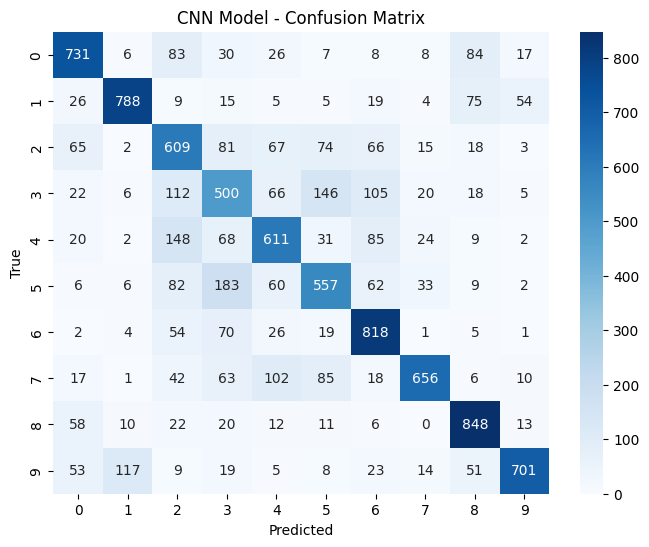

In [20]:
# Train and evaluate CNN Model
print("\nTraining CNN Model on modified CIFAR10 dataset:")
cnn_model = build_cnn_model()
cnn_test_acc = train_and_evaluate(cnn_model, X_train_transformed, y_train, X_test_transformed, y_test, model_name="CNN Model")


Training ViT Model on modified CIFAR10 dataset:
Epoch 1/10
1407/1407 - 70s - 50ms/step - accuracy: 0.2853 - loss: 1.9584 - val_accuracy: 0.3376 - val_loss: 1.8299
Epoch 2/10
1407/1407 - 58s - 41ms/step - accuracy: 0.3843 - loss: 1.7195 - val_accuracy: 0.4178 - val_loss: 1.6116
Epoch 3/10
1407/1407 - 62s - 44ms/step - accuracy: 0.4330 - loss: 1.5906 - val_accuracy: 0.4400 - val_loss: 1.5738
Epoch 4/10
1407/1407 - 72s - 52ms/step - accuracy: 0.4532 - loss: 1.5263 - val_accuracy: 0.4592 - val_loss: 1.4972
Epoch 5/10
1407/1407 - 64s - 45ms/step - accuracy: 0.4693 - loss: 1.4833 - val_accuracy: 0.4670 - val_loss: 1.4717
Epoch 6/10
1407/1407 - 60s - 42ms/step - accuracy: 0.4796 - loss: 1.4542 - val_accuracy: 0.4592 - val_loss: 1.4940
Epoch 7/10
1407/1407 - 64s - 45ms/step - accuracy: 0.4878 - loss: 1.4361 - val_accuracy: 0.4560 - val_loss: 1.4855
Epoch 8/10
1407/1407 - 57s - 41ms/step - accuracy: 0.4962 - loss: 1.4067 - val_accuracy: 0.4826 - val_loss: 1.4512
Epoch 9/10
1407/1407 - 57s - 40

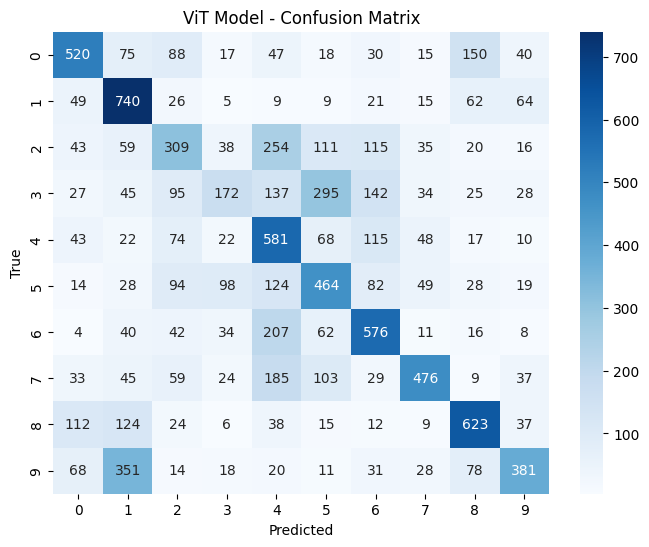

In [21]:
print("\nTraining ViT Model on modified CIFAR10 dataset:")
vit_model = EnhancedVisionTransformer(patch_size=8)
vit_test_acc = train_and_evaluate(vit_model, X_train_transformed, y_train, X_test_transformed, y_test, model_name="ViT Model")